**If you are using Colab. Please run the code under this text.**

In [1]:
# Install required libraries for the entire notebook environment
!pip install torch numpy matplotlib datasets scikit-learn tqdm gensim transformers pandas huggingface_hub safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 34.1 MB/s eta 0:00:00


In [2]:
# Core library imports: data handling, modeling, evaluation, and visualization

# Library imports for data processing, modeling, and evaluation
import os, time, random, re
import numpy as np, matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm.auto import tqdm
import gensim.downloader as api
from transformers import AutoTokenizer, AutoModel

# Prefer GPU execution when available to accelerate training
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Seed all random number generators for reproducibility
SEED=42; random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False

# Config
MAX_LEN=300; MAX_LEN_CTX=256
BATCH_TRAIN=64; BATCH_EVAL=128; EPOCHS=3; LR=1e-3
DROPOUT=0.3; NUM_LAYERS=2; HIDDEN_SIZE=128
STATIC_DIM=300; VOCAB_SIZE=30000; LOWERCASE=True
CTX_MODEL_NAME='distilbert-base-uncased'; CTX_DIM=768; FREEZE_CONTEXTUAL=True
CONV_THRESHOLD=0.99
print('Device:', DEVICE)


Device: cuda


In [3]:

# Load IMDb
# Pull the IMDb reviews dataset via HuggingFace Datasets
imdb = load_dataset("imdb")
# Split the official training set into train/validation folds reproducibly
splits = imdb["train"].train_test_split(test_size=0.1, seed=SEED)
train_ds = splits["train"]; val_ds = splits["test"]; test_ds = imdb["test"]
print(len(train_ds), len(val_ds), len(test_ds))


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

22500 2500 25000


In [4]:

# Static tokenizer & vocab
# Regex captures words plus punctuation tokens needed for the vocab
TOKEN_RE = re.compile(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?|[.!?;,()\-\:]")
PAD, UNK = "<pad>", "<unk>"
def tokenize(t, lower=LOWERCASE):
    if lower: t=t.lower()
    return TOKEN_RE.findall(t)

from collections import Counter
def build_vocab(dataset_iter, vocab_size=VOCAB_SIZE):
    c=Counter()
    # Count how often each token appears in the corpus
    for ex in dataset_iter: c.update(tokenize(ex["text"]))
    most=[w for w,_ in c.most_common(vocab_size-2)]
    stoi={PAD:0, UNK:1}
    for i,w in enumerate(most, start=2): stoi[w]=i
    itos={i:s for s,i in stoi.items()}
    return stoi, itos

stoi, itos = build_vocab(train_ds, VOCAB_SIZE)
len(stoi)


30000

In [5]:

# GloVe (fallback to random if download not available)
def load_static_embeddings(stoi, dim=STATIC_DIM):
    # Initialize embeddings with random values as a fallback
    emb = np.random.normal(scale=0.1, size=(len(stoi), dim)).astype(np.float32)
    emb[0]=0.0
    # Attempt to download pre-trained embeddings from Gensim
    try:
        vecs = api.load("glove-wiki-gigaword-300")
    except Exception as e:
        print("Static vectors unavailable, using random. Err:", e)
        return torch.tensor(emb)
    hit=0
    for w,idx in stoi.items():
        if w in (PAD,UNK): continue
        # Replace random vectors with the pre-trained embedding when available
        if w in vecs:
            emb[idx]=vecs[w]; hit+=1
    print(f"Loaded {hit}/{len(stoi)} tokens from static vectors.")
    return torch.tensor(emb)

emb_matrix = load_static_embeddings(stoi, STATIC_DIM)
emb_matrix.shape


[==================================================] 100.0% 376.1/376.1MB downloaded
Loaded 28164/30000 tokens from static vectors.


torch.Size([30000, 300])

In [6]:

# Datasets & loaders (static)
def numericalize(tokens, stoi_map, max_len=MAX_LEN):
    # Map tokens to ids and truncate to the configured max length
    ids=[stoi_map.get(t, stoi_map[UNK]) for t in tokens][:max_len]
    # Pad shorter sequences with the PAD token so tensors share a length
    if len(ids)<max_len: ids += [stoi_map[PAD]]*(max_len-len(ids))
    return ids

# Dataset wrapper that emits padded token ids with sentiment labels
class StaticIMDB(Dataset):
    def __init__(self, hf_split, stoi): self.data=hf_split; self.stoi=stoi
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        ex=self.data[idx]
        x=torch.tensor(numericalize(tokenize(ex["text"]), self.stoi), dtype=torch.long)
        y=torch.tensor(ex["label"], dtype=torch.long)
        return x,y

# Instantiate dataset splits for the static embedding pipeline
train_static=StaticIMDB(train_ds, stoi); val_static=StaticIMDB(val_ds, stoi); test_static=StaticIMDB(test_ds, stoi)
# Build dataloaders to stream batches for training/validation/testing
train_loader_static = DataLoader(train_static, batch_size=BATCH_TRAIN, shuffle=True, num_workers=0, pin_memory=True)
val_loader_static   = DataLoader(val_static,   batch_size=BATCH_EVAL, shuffle=False, num_workers=0, pin_memory=True)
test_loader_static  = DataLoader(test_static,  batch_size=BATCH_EVAL, shuffle=False, num_workers=0, pin_memory=True)


In [7]:

# Contextual pipeline
tok = AutoTokenizer.from_pretrained(CTX_MODEL_NAME)
# Dataset wrapper that tokenizes reviews with the transformer tokenizer
class ContextualIMDB(Dataset):
    def __init__(self, hf_split, tokenizer, max_len=MAX_LEN_CTX):
        self.data=hf_split; self.tok=tokenizer; self.max_len=max_len
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        ex=self.data[idx]
        # Tokenize the review into fixed-length transformer inputs
        enc=self.tok(ex["text"], truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
        item={k:v.squeeze(0) for k,v in enc.items()}
        y=torch.tensor(ex["label"], dtype=torch.long)
        return item, y

# Construct contextual dataset splits using the pretrained tokenizer
train_ctx=ContextualIMDB(train_ds, tok, MAX_LEN_CTX)
val_ctx  =ContextualIMDB(val_ds,   tok, MAX_LEN_CTX)
test_ctx =ContextualIMDB(test_ds,  tok, MAX_LEN_CTX)
# Build dataloaders that serve transformer inputs to the contextual models
train_loader_ctx=DataLoader(train_ctx, batch_size=BATCH_TRAIN, shuffle=True, num_workers=0, pin_memory=True)
val_loader_ctx  =DataLoader(val_ctx,   batch_size=BATCH_EVAL, shuffle=False, num_workers=0, pin_memory=True)
test_loader_ctx =DataLoader(test_ctx,  batch_size=BATCH_EVAL, shuffle=False, num_workers=0, pin_memory=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
# Bidirectional LSTM classifier on top of frozen contextual embeddings.
# The transformer encoder generates token representations; the BiLSTM
# aggregates them, and a linear head predicts sentiment.

# Models
class StaticBiRNN(nn.Module):
    def __init__(self, emb_matrix, hidden=128, layers=2, drop=0.3, rnn_type='lstm'):
        super().__init__()
        V,E = emb_matrix.size()
        self.embedding = nn.Embedding(V,E,padding_idx=0)
        # Load pre-trained embeddings while keeping them trainable
        self.embedding.weight.data.copy_(emb_matrix); self.embedding.weight.requires_grad=True
        rnn = nn.LSTM if rnn_type=='lstm' else nn.GRU
        # Bi-directional RNN encodes token sequences from both directions
        self.rnn = rnn(E, hidden, num_layers=layers, batch_first=True, dropout=drop if layers>1 else 0.0, bidirectional=True)
        self.dropout = nn.Dropout(drop); self.fc = nn.Linear(hidden*2,1)
    def forward(self, x):
        out,_ = self.rnn(self.embedding(x))
        # Use the final timestep as a summary representation with dropout
        last = self.dropout(out[:, -1, :])
        return self.fc(last).squeeze(1), last

class ContextualFeaturizer(nn.Module):
    def __init__(self, name='distilbert-base-uncased', freeze=True):
        super().__init__()
        # Load the transformer backbone that yields contextual embeddings
        self.m = AutoModel.from_pretrained(name)
        if freeze:
            # Freeze transformer weights when feature extraction is enough
            for p in self.m.parameters(): p.requires_grad=False
    def forward(self, input_ids, attention_mask):
        return self.m(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

class ContextualBiRNN(nn.Module):
    def __init__(self, hidden=128, layers=2, drop=0.3, rnn_type='lstm'):
        super().__init__()
        self.f = ContextualFeaturizer(CTX_MODEL_NAME, True)
        rnn = nn.LSTM if rnn_type=='lstm' else nn.GRU
        # RNN consumes transformer features to produce sequence encodings
        self.rnn = rnn(768, hidden, num_layers=layers, batch_first=True, dropout=drop if layers>1 else 0.0, bidirectional=True)
        self.dropout = nn.Dropout(drop); self.fc = nn.Linear(hidden*2,1)
    def forward(self, batch):
        ctx = self.f(batch["input_ids"].to(DEVICE), batch["attention_mask"].to(DEVICE))
        out,_ = self.rnn(ctx)
        last = self.dropout(out[:, -1, :])
        return self.fc(last).squeeze(1), last


In [9]:

# Train/Eval utilities
# Execute one pass over a dataloader and return loss/accuracy/F1
def run_epoch(model, loader, train=True):
    model.train(mode=train); crit=nn.BCEWithLogitsLoss()
    if train: opt=model._opt
    # Track predictions, probabilities, and aggregate loss statistics
    ys=[]; ps=[]; tot_loss=0; n=0
    for batch in tqdm(loader, leave=False):
        # Support contextual batches delivered as dictionaries
        if isinstance(batch[0], dict):
            x,y = batch; y=y.to(DEVICE).float()
            logits, feats = model({k:v.to(DEVICE) for k,v in x.items()})
        else:
            x,y = batch; x=x.to(DEVICE); y=y.to(DEVICE).float()
            logits, feats = model(x)
        loss = crit(logits,y)
        # Only backpropagate and step the optimizer during training
        if train: opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
        tot_loss += loss.item()*y.size(0); n += y.size(0)
        ps.append(torch.sigmoid(logits).detach().cpu().numpy()); ys.append(y.detach().cpu().numpy())
    # Convert sigmoid outputs into binary predictions for metrics
    ys=np.concatenate(ys); ps=np.concatenate(ps); preds=(ps>=0.5).astype(int)
    return tot_loss/n, accuracy_score(ys,preds), f1_score(ys,preds,average='macro')

# Train the model while recording history and early convergence stats
def train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR):
    # Optimize only parameters that require gradients (frozen layers excluded)
    model.to(DEVICE); model._opt=torch.optim.Adam(filter(lambda p:p.requires_grad, model.parameters()), lr=lr)
    hist={"tr_loss":[], "tr_acc":[], "tr_f1":[], "va_loss":[], "va_acc":[], "va_f1":[]}
    best=0.0; start=time.time(); t_to_conv=None
    for ep in range(1,epochs+1):
        # Training phase: update parameters and gather metrics
        tl,ta,tf = run_epoch(model, train_loader, True)
        # Validation phase: evaluate on held-out data without gradient updates
        vl,va,vf = run_epoch(model, val_loader, False)
        hist["tr_loss"].append(tl); hist["tr_acc"].append(ta); hist["tr_f1"].append(tf)
        hist["va_loss"].append(vl); hist["va_acc"].append(va); hist["va_f1"].append(vf)
        best = max(best, va)
        if t_to_conv is None and best>0 and va >= 0.99*best: t_to_conv = time.time()-start
        print(f"Epoch {ep}/{epochs} | tr_loss={tl:.4f} acc={ta:.3f} f1={tf:.3f} | val_loss={vl:.4f} acc={va:.3f} f1={vf:.3f}")
    total=time.time()-start
    # Fallback: if convergence threshold never met, use full training time
    if t_to_conv is None: t_to_conv=total
    return hist, best, t_to_conv, total

@torch.no_grad()
def test_model(model, loader):
    l,a,f = run_epoch(model, loader, False)
    return {"loss":l,"acc":a,"f1":f}


In [10]:
# Run all four combos
# Collect results for each model variant
results=[]
# Train and evaluate the models
m_s_lstm = StaticBiRNN(emb_matrix, HIDDEN_SIZE, NUM_LAYERS, DROPOUT, 'lstm'); h1,b1,t1,tt1 = train_model(m_s_lstm, train_loader_static, val_loader_static); r1=test_model(m_s_lstm, test_loader_static); results.append({"Model":"BiLSTM-Static","TestAcc":r1["acc"],"TestF1":r1["f1"],"T_toConv(s)":t1,"T_total(s)":tt1})
m_s_gru  = StaticBiRNN(emb_matrix, HIDDEN_SIZE, NUM_LAYERS, DROPOUT, 'gru');  h2,b2,t2,tt2 = train_model(m_s_gru,  train_loader_static, val_loader_static); r2=test_model(m_s_gru,  test_loader_static); results.append({"Model":"BiGRU-Static","TestAcc":r2["acc"],"TestF1":r2["f1"],"T_toConv(s)":t2,"T_total(s)":tt2})
m_c_lstm = ContextualBiRNN(HIDDEN_SIZE, NUM_LAYERS, DROPOUT, 'lstm'); h3,b3,t3,tt3 = train_model(m_c_lstm, train_loader_ctx, val_loader_ctx); r3=test_model(m_c_lstm, test_loader_ctx); results.append({"Model":"BiLSTM-Contextual","TestAcc":r3["acc"],"TestF1":r3["f1"],"T_toConv(s)":t3,"T_total(s)":tt3})
m_c_gru  = ContextualBiRNN(HIDDEN_SIZE, NUM_LAYERS, DROPOUT, 'gru');  h4,b4,t4,tt4 = train_model(m_c_gru,  train_loader_ctx, val_loader_ctx); r4=test_model(m_c_gru,  test_loader_ctx); results.append({"Model":"BiGRU-Contextual","TestAcc":r4["acc"],"TestF1":r4["f1"],"T_toConv(s)":t4,"T_total(s)":tt4})
import pandas as pd
display(pd.DataFrame(results).sort_values("TestAcc", ascending=False).reset_index(drop=True))


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/3 | tr_loss=0.6885 acc=0.522 f1=0.520 | val_loss=0.6900 acc=0.526 f1=0.441


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/3 | tr_loss=0.6673 acc=0.576 f1=0.575 | val_loss=0.6884 acc=0.541 f1=0.520


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/3 | tr_loss=0.5146 acc=0.761 f1=0.761 | val_loss=0.4795 acc=0.803 f1=0.801


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/3 | tr_loss=0.6835 acc=0.531 f1=0.530 | val_loss=0.6287 acc=0.603 f1=0.567


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/3 | tr_loss=0.4719 acc=0.778 f1=0.776 | val_loss=0.3446 acc=0.858 f1=0.858


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/3 | tr_loss=0.2623 acc=0.894 f1=0.894 | val_loss=0.3091 acc=0.885 f1=0.885


  0%|          | 0/196 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/3 | tr_loss=0.5066 acc=0.750 f1=0.750 | val_loss=0.4413 acc=0.792 f1=0.791


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/3 | tr_loss=0.4165 acc=0.815 f1=0.815 | val_loss=0.3328 acc=0.864 f1=0.863


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/3 | tr_loss=0.3219 acc=0.867 f1=0.867 | val_loss=0.2846 acc=0.888 f1=0.888


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/3 | tr_loss=0.4019 acc=0.814 f1=0.814 | val_loss=0.2788 acc=0.886 f1=0.886


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/3 | tr_loss=0.2723 acc=0.886 f1=0.886 | val_loss=0.2640 acc=0.888 f1=0.888


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/3 | tr_loss=0.2464 acc=0.898 f1=0.898 | val_loss=0.2621 acc=0.902 f1=0.902


  0%|          | 0/196 [00:00<?, ?it/s]

,Model,TestAcc,TestF1,T_toConv(s),T_total(s)
0,BiGRU-Contextual,0.89776,0.897676,210.812673,633.355833
1,BiLSTM-Contextual,0.88764,0.887638,219.698702,652.603255
2,BiGRU-Static,0.84812,0.847954,17.690919,52.857924
3,BiLSTM-Static,0.78024,0.776994,25.575337,91.205487


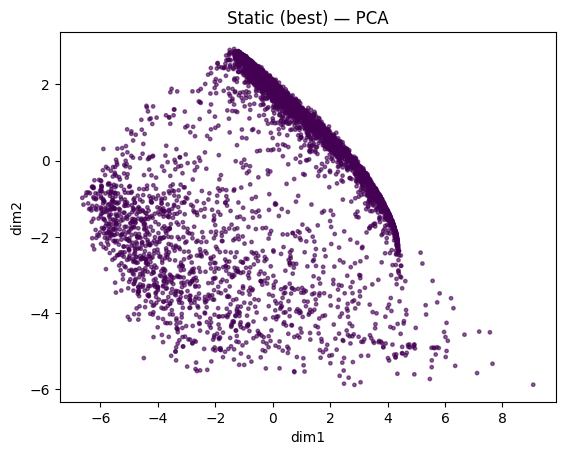

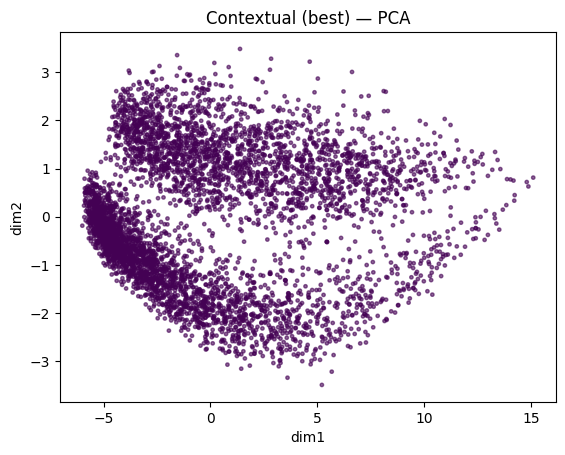

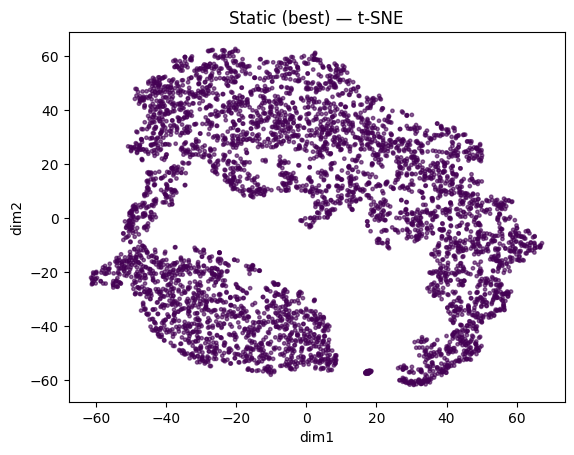

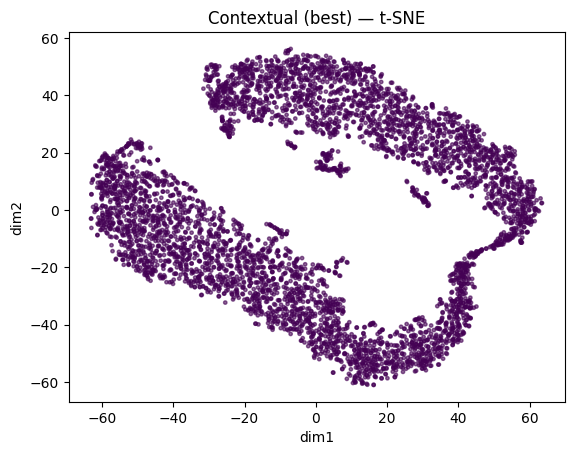

In [11]:
# Feature extraction utilities for visualization.
# collect_features: records intermediate representations and labels
# to feed into PCA / t-SNE for latent-space analysis.

# Visualize latent features (PCA & t-SNE) for best static vs best contextual
# Disable gradient tracking while extracting features for visualization
@torch.no_grad()
# Gather intermediate representations and labels from the supplied loader
def collect_features(model, loader, max_batches=50):
    feats=[]; labels=[]; c=0; model.eval()
    for batch in loader:
        # Handle contextual feature batches that arrive as dictionaries
        if isinstance(batch[0], dict):
            x,y=batch; logits,f=model({k:v.to(DEVICE) for k,v in x.items()})
        else:
            x,y=batch; logits,f=model(x.to(DEVICE))
        # Cache feature vectors and labels on the CPU for later reduction
        feats.append(f.detach().cpu().numpy()); labels.append(y.numpy())
        c+=1
        if c>=max_batches: break
    import numpy as np
    return np.concatenate(feats), np.concatenate(labels)

# Pick the stronger static model based on validation accuracy
best_static = m_s_gru if b2 >= b1 else m_s_lstm
best_ctx    = m_c_gru if b4 >= b3 else m_c_lstm

# Collect features from the chosen static and contextual models
f_s, y_s = collect_features(best_static, test_loader_static, max_batches=40)
f_c, y_c = collect_features(best_ctx,    test_loader_ctx,    max_batches=40)

# Reduce feature dimensionality with PCA or t-SNE for visualization
def plot_embed(feats, labels, title, method='pca'):
    if method=='pca':
        red = PCA(n_components=2, random_state=SEED)
    else:
        red = TSNE(n_components=2, random_state=SEED, init='pca', learning_rate='auto', perplexity=30)
    # Project high-dimensional features into two dimensions
    Z = red.fit_transform(feats)
    import matplotlib.pyplot as plt
    # Plot the embeddings colored by label to inspect class separation
    plt.figure(); plt.scatter(Z[:,0], Z[:,1], c=labels, s=6, alpha=0.6); plt.title(title); plt.xlabel('dim1'); plt.ylabel('dim2'); plt.show()

plot_embed(f_s, y_s, "Static (best) — PCA", 'pca')
plot_embed(f_c, y_c, "Contextual (best) — PCA", 'pca')
plot_embed(f_s, y_s, "Static (best) — t-SNE", 'tsne')
plot_embed(f_c, y_c, "Contextual (best) — t-SNE", 'tsne')
